# **Programming for Data Analysis**
---

**Author: Damien Farrell**

---

## **Project 2: An Analysis of Paleo-Present Climate Data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import requests
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

sns.set_theme()

### **Data Set Components**

#### **Antarctic Datasets**

1. **Temperature Estimate:** [1] [2] [8] [9]
   - Temperature difference anomaly from the average temperature of the last 1000 years over the past 800,000 years.
   - Temperature estimated from the analysis of deuterium in the ice cores, with various corrections.
     <br>
     <br>

1. **Composite Carbon Dioxide Record:** [1] [2] [8] [9]
   - Composite record of atmospheric carbon dioxide (CO2) levels over the past 800,000 years.
   - Antarctic ice-core records of carbon dioxide extend back 800,000 years at Dome C and over 400,000 years at the Vostok site. Additional shorter recordS from Taylor Dome, another Antarctic location.
     <br>
     <br>

1. **Methane Record (EPICA Dome C Ice Core):** [1] [2] [8] [9]
   - Detailed methane record to 800,000 years before AD 1950.
     <br>

#### **Irish Datasets**

1. **Valentia Observatory Data:** [16]
   - Detailed weather data from Valentia Observatory.
     <br>
     <br>

1. **Rainfall Data:** [10]
   - Composite Rainfall Time Series from 1711-2016 for Ireland.
     <br>
     <br>

### **Antarctic Datasets**

In [2]:
present_year = 1950

Making a full year range as it impossible to use date.time or period on a time period this length. Cannot resample either as it is only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex. [3] [5]

In [3]:
min_year = -850_000
max_year = 2100
year_range = pd.Series(range(min_year, max_year + 1), name="year")

#### **Antarctic Temperature**
Extract temperature data from NOAA EDC3 2007 and convert into a DataFrame. [6] [17]

In [4]:
url = "https://www.ncei.noaa.gov/pub/data/paleo/icecore/antarctica/epica_domec/edc3deuttemp2007.txt"
response = requests.get(url)  # Generate response object
text = response.text  # Return the HTML of webpage as string
data = text

# The pattern to find the start of the table
pattern = re.compile(r"Bag\s+ztop\s+Age\s+Deuterium\s+Temperature", re.IGNORECASE)

# Extract the data starting from the match
match = pattern.search(data)
start_index = match.start()
table_data = data[start_index:]

# Convert the table_data to a list of lines
table_lines = table_data.strip().split("\n")

# Extract column names and data
columns = table_lines[0].split()
rows = [line.split() for line in table_lines[1:]]

# Create a Antarctic Temperature DataFrame
antarctic_temp_df = pd.DataFrame(rows, columns=columns)
numeric_columns = ["Bag", "ztop", "Age", "Deuterium", "Temperature"]
antarctic_temp_df[numeric_columns] = antarctic_temp_df[numeric_columns].apply(pd.to_numeric, errors="coerce")

# Transforming the Antarctic Temperature DataFrame
antarctic_temp_df = antarctic_temp_df.dropna().reset_index(drop=True)
antarctic_temp_df.drop(["Bag", "ztop", "Deuterium"], axis=1, inplace=True)
antarctic_temp_df["year"] = present_year - antarctic_temp_df["Age"].astype(int)
antarctic_temp_df.drop(["Age"], axis=1, inplace=True)
antarctic_temp_df.rename(columns={"Temperature": "temp anomaly (°C)"}, inplace=True)
antarctic_temp_df = antarctic_temp_df.drop_duplicates(subset="year")

#### **Antarctic Carbon Dioxide**
Extract carbon dioxide data from the Composite CO2 record (0-800 kyr BP) and convert into a DataFrame. [12]

In [5]:
antarctic_carbon_dioxide_df = pd.read_excel(
    "./data/CO2/grl52461-sup-0003-supplementary.xls",
    sheet_name="CO2 Composite",
    skiprows=14,
)

# Transforming the Antarctic CO2 DataFrame
antarctic_carbon_dioxide_df.drop(["sigma mean CO2 (ppmv)"], axis=1, inplace=True)
antarctic_carbon_dioxide_df["year"] = present_year - antarctic_carbon_dioxide_df[
    "Gasage (yr BP) "
].astype(int)
antarctic_carbon_dioxide_df.drop(["Gasage (yr BP) "], axis=1, inplace=True)
antarctic_carbon_dioxide_df = antarctic_carbon_dioxide_df.drop_duplicates(subset="year")

#### **Antarctic Methane**
Extract methane EPICA Dome C Ice Core (0-800 kyr BP) and convert into a DataFrame.

In [6]:
# URL of the data
url = "https://www.ncei.noaa.gov/pub/data/paleo/icecore/antarctica/epica_domec/edc-ch4-2008.txt"

# Fetching the data
response = requests.get(url)
text = response.text

# The pattern to find the start of the table
pattern = re.compile(r"Depth\s+Gas Age\s+CH4 mean\s+1s\s+Lab.", re.IGNORECASE)

# Extract the data starting from the match
match = pattern.search(text)
start_index = match.start()
table_data = text[start_index:]


# Convert the table_data to a list of lines
table_lines = table_data.strip().split("\n")

# Extract column names and data
columns = ["Depth", "Gas Age", "CH4 mean", "1s", "Lab."]
rows = [line.split() for line in table_lines[1:] if line.strip()]

# Create a DataFrame
antarctic_epica_methane_df = pd.DataFrame(rows, columns=columns)
numeric_columns = ["Depth", "Gas Age", "CH4 mean", "1s"]
antarctic_epica_methane_df[numeric_columns] = antarctic_epica_methane_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Transforming the Antarctic Methane DataFrame
antarctic_epica_methane_df = antarctic_epica_methane_df.dropna().reset_index(drop=True)
antarctic_epica_methane_df.drop(["Depth", "1s", "Lab."], axis=1, inplace=True)
antarctic_epica_methane_df["year"] = present_year - antarctic_epica_methane_df["Gas Age"].astype(int)
antarctic_epica_methane_df.drop(["Gas Age"], axis=1, inplace=True)
antarctic_epica_methane_df.rename(columns={"CH4 mean": "CH4 (ppbv)"}, inplace=True)
antarctic_epica_methane_df = antarctic_epica_methane_df.drop_duplicates(subset="year")

Extract methane and carbon dioxide data from the Law Dome CH4 CO2 0-2000 AD and convert into a DataFrame.

In [7]:
antarctic_law_dome_co2_df = pd.read_excel(
    "./data/CH4/Historic_Greenhouse_gas_concentrations_ice_core_data spreadsheet.xlsx",
    sheet_name="Law Dome_CH4_CO2_0-2000 AD",
    skiprows=0,
)

antarctic_law_dome_methane_df = pd.read_excel(
    "./data/CH4/Historic_Greenhouse_gas_concentrations_ice_core_data spreadsheet.xlsx",
    sheet_name="CH4_EDC",
    skiprows=1,
)

# Transforming the Antarctic Methane DataFrame 2
antarctic_law_dome_co2_df.rename(columns={"Year AD": "year", "CH4  (ppb)": "CH4 (ppbv)", "CO2  (ppm)": "CO2 (ppmv)"}, inplace=True)
antarctic_law_dome_co2_df = antarctic_law_dome_co2_df.drop_duplicates(subset="year")

# Transforming the Antarctic Methane DataFrame 3
antarctic_law_dome_methane_df.drop(["[m]", "[ppbv].1", "[b, g]"], axis=1, inplace=True)
antarctic_law_dome_methane_df["year"] = present_year - antarctic_law_dome_methane_df["[yrs BP 1950]"].astype(int)
antarctic_law_dome_methane_df.drop(["[yrs BP 1950]"], axis=1, inplace=True)
antarctic_law_dome_methane_df.rename(columns={"[ppbv]": "CH4 (ppbv)"}, inplace=True)
antarctic_law_dome_methane_df = antarctic_law_dome_methane_df.drop_duplicates(subset="year")

# Merging Methane DataFrame 1, 2, & 3
antarctic_methane_df = pd.merge(antarctic_epica_methane_df, antarctic_law_dome_co2_df , on="year", how="outer")
antarctic_methane_df = pd.merge(antarctic_methane_df, antarctic_law_dome_methane_df, on="year", how="outer")
antarctic_methane_df['CH4 (ppbv)'] = antarctic_methane_df['CH4 (ppbv)_x'].combine_first(antarctic_methane_df['CH4 (ppbv)_y'])
antarctic_methane_df.drop(['CH4 (ppbv)_x', 'CH4 (ppbv)_y'], axis=1, inplace=True)

#### **Combined Antarctic DataFrame**
Transform the datasets into a combined DataFrame. [11]

In [8]:
antarctic_df = pd.merge(year_range, antarctic_temp_df, on="year", how="left")
antarctic_df = pd.merge(antarctic_df, antarctic_carbon_dioxide_df, on="year", how="left")

antarctic_df = pd.merge(antarctic_df, antarctic_methane_df, on="year", how="left")
antarctic_df = antarctic_df.set_index("year")
antarctic_df = antarctic_df.sort_index()

# Merging CO2 Columns
antarctic_df['CO2 (ppmv)'] = antarctic_df['CO2 (ppmv)_x'].combine_first(antarctic_df['CO2 (ppmv)_y'])
antarctic_df.drop(['CO2 (ppmv)_x', 'CO2 (ppmv)_y'], axis=1, inplace=True)

# Filter the dataset to remove rows where all of temp, CO2, and CH4 are NaN
antarctic_df = antarctic_df.dropna(subset=["temp anomaly (°C)", "CO2 (ppmv)", "CH4 (ppbv)"], how="all")

In [9]:
antarctic_df

,temp anomaly (°C),CH4 (ppbv),CO2 (ppmv)
year,,,
-803718,NaN,NaN,207.285440
-803182,NaN,NaN,202.226839
-802572,NaN,NaN,204.861938
-802059,NaN,NaN,207.498645
-801975,NaN,NaN,202.921723
...,...,...,...
2000,NaN,1703.401,366.822800
2001,NaN,1706.518,368.022488
2002,NaN,1708.259,370.641500


### **Relationships in the Antarctic DataFrame**

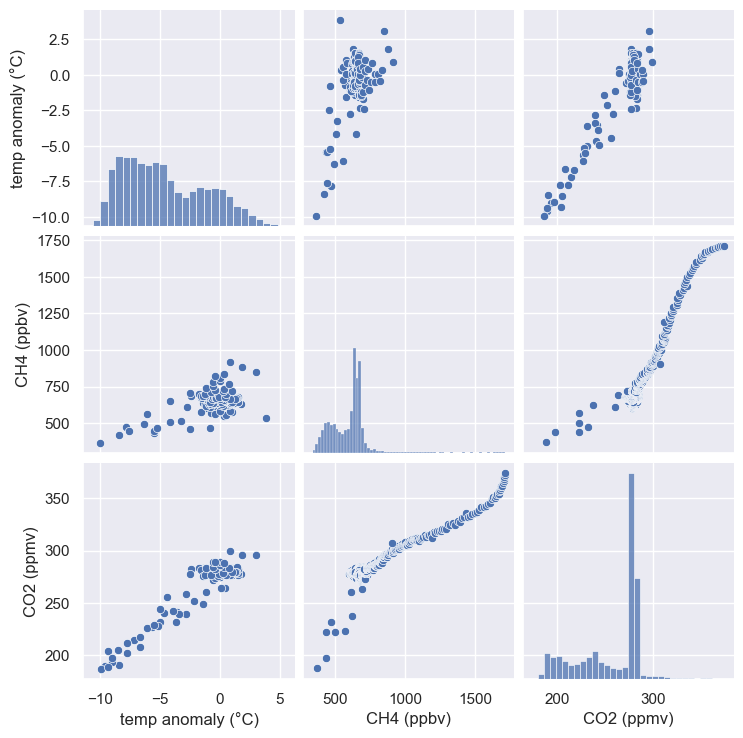

In [10]:
sns.pairplot(antarctic_df);

The pairplot shows a positive correlation between the variables.

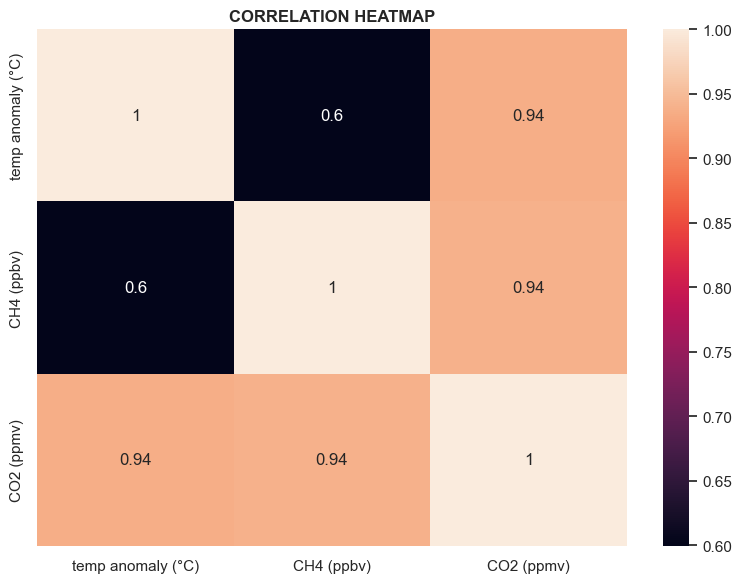

In [11]:
plt.figure(figsize=(8, 6))
sns.heatmap(antarctic_df.corr(), annot=True)
plt.title("CORRELATION HEATMAP", fontweight="bold")
plt.tight_layout()

The correlation between temperature anomaly and the levels of carbon dioxide and methane is extremely strong, with a coefficient of 0.94.

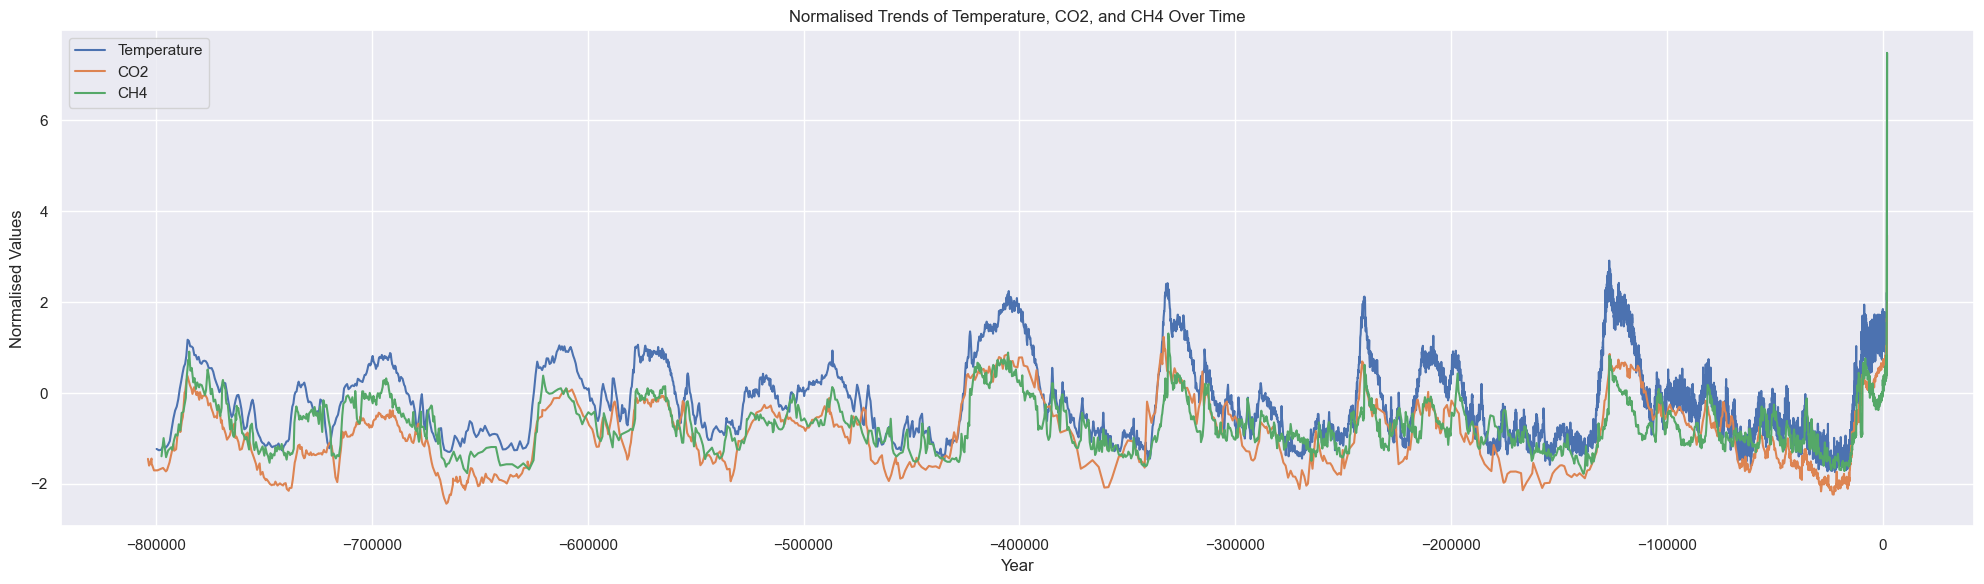

In [12]:
plt.figure(figsize=(20, 6))

# Normalising the data for overlaying
normalised_data = (
    antarctic_df[["temp anomaly (°C)", "CO2 (ppmv)", "CH4 (ppbv)"]] - antarctic_df[["temp anomaly (°C)", "CO2 (ppmv)", "CH4 (ppbv)"]].mean()) / antarctic_df[["temp anomaly (°C)", "CO2 (ppmv)", "CH4 (ppbv)"]].std()

# Overlaying the plots
sns.lineplot(data=normalised_data, x=antarctic_df.index, y="temp anomaly (°C)", label="Temperature")
sns.lineplot(data=normalised_data, x=antarctic_df.index, y="CO2 (ppmv)", label="CO2")
sns.lineplot(data=normalised_data, x=antarctic_df.index, y="CH4 (ppbv)", label="CH4")

plt.title("Normalised Trends of Temperature, CO2, and CH4 Over Time")
plt.ylabel("Normalised Values")
plt.xlabel("Year")
plt.legend()
plt.tight_layout();

The plot above displays the normalised trends of temperature, carbon dioxide (CO2), and methane (CH4) over time. Normalisation was performed to bring the different scales of these variables onto a comparable level, allowing for a more meaningful comparison of their trends. It can be seen how the trends in temperature and carbon dioxide align over the years. [4] [7]

### **Irish Weather Datasets**

Importing, cleaning, and transforming the Irish temperature weather data.

In [13]:
irish_weather_df = pd.read_csv(
    "./data/irish/mly2275.csv",
    sep=",",
    skiprows=19,
    usecols=["year", "month", "meant", "rain"],
)

irish_weather_df['date'] = pd.to_datetime(irish_weather_df[['year', 'month']].assign(DAY=1))
irish_weather_df.rename(columns={"rain": "irish rainfall (mm)"}, inplace=True)
irish_weather_df.set_index('date', inplace=True)
irish_weather_df.drop(columns=['year', 'month'], inplace=True)

In [14]:
# Reading in the csv file
irish_temp_df1 = pd.read_csv(
    "./data/irish/Valentia-Observatory_second-order-station_1883-1909.csv",
    sep=",",
    encoding="ISO-8859-1")

# Transforming the dataset
irish_temp_df1.drop(["Max (°F)", "Min (°F)"], axis=1, inplace=True)
irish_temp_df1["meant"] = irish_temp_df1[["Max (°C)", "Min (°C)"]].mean(axis=1)
irish_temp_df1.drop(["Max (°C)", "Min (°C)"], axis=1, inplace=True)
irish_temp_df1.rename(columns={"Year": "year", "Month": "month", "Day ": "day"}, inplace=True)
irish_temp_df1["date"] = pd.to_datetime(irish_temp_df1[["year", "month", "day"]], errors="coerce")
irish_temp_df1 = irish_temp_df1.drop(["year", "month", "day"], axis=1)

# Reading in the csv file
irish_temp_df2 = pd.read_csv(
    "./data/irish/Valentia-Observatory-telegraphic-reporting-station_1850-1920.csv",
    sep=",",
    encoding="ISO-8859-1")

# Transforming the dataset
irish_temp_df2.drop(["Max (°F)", "Min (°F)"], axis=1, inplace=True)
irish_temp_df2["meant"] = irish_temp_df2[["Max (°C)", "Min (°C)"]].mean(axis=1)
irish_temp_df2.drop(["Max (°C)", "Min (°C)"], axis=1, inplace=True)
irish_temp_df2.rename(columns={"Year": "year", "Month": "month", "Day": "day"}, inplace=True)
irish_temp_df2["date"] = pd.to_datetime(irish_temp_df2[["year", "month", "day"]], errors="coerce")
irish_temp_df2 = irish_temp_df2.drop(["year", "month", "day"], axis=1)

# Reading in the csv file
irish_temp_df3 = pd.read_csv(
    "./data/irish/Valentia-Observatory-telegraphic-reporting-station_1921-1943.csv",
    sep=",",
    encoding="ISO-8859-1")

# Transforming the dataset
irish_temp_df3.drop(["Max at 7h (°F)", "Min at 7h (°F)", "Max at 18h (°F)", "Min at 18h (°F)"],axis=1,inplace=True,)
irish_temp_df3["meant"] = irish_temp_df3[["Max at 7h (°C)", "Min at 7h (°C)", "Max at 18h (°C)", "Min at 18h (°C)"]].mean(axis=1)
irish_temp_df3.drop(["Max at 7h (°C)", "Min at 7h (°C)", "Max at 18h (°C)", "Min at 18h (°C)"], axis=1, inplace=True,)
irish_temp_df3.rename(columns={"Year": "year", "Month": "month", "Daily": "day"}, inplace=True)
irish_temp_df3["date"] = pd.to_datetime(irish_temp_df3[["year", "month", "day"]], errors="coerce")
irish_temp_df3 = irish_temp_df3.drop(["year", "month", "day"], axis=1)

# Combining the datasets
irish_temp_df = pd.concat([irish_temp_df1, irish_temp_df2, irish_temp_df3])
irish_temp_df.set_index('date', inplace=True)

#### **Combined Irish DataFrame**

Transform the datasets into a combined DataFrame.

In [15]:
irish_weather_df  = pd.merge(irish_weather_df, irish_temp_df, left_index=True, right_index=True, how="outer")
irish_weather_df['irish temp (°C)'] = irish_weather_df['meant_x'].combine_first(irish_weather_df['meant_y'])
irish_weather_df.drop(['meant_x', 'meant_y'], axis=1, inplace=True)
irish_weather_df = irish_weather_df[~irish_weather_df.index.duplicated(keep='first')]
irish_weather_df = irish_weather_df.dropna(subset=["irish temp (°C)", "irish rainfall (mm)"], how="all")
irish_weather_df['month'] = irish_weather_df.index.month
irish_weather_df['year'] = irish_weather_df.index.year
irish_weather_df

,irish rainfall (mm),irish temp (°C),month,year
date,,,,
1850-10-19,NaN,14.4,10,1850
1850-10-20,NaN,13.1,10,1850
1850-10-21,NaN,10.5,10,1850
1850-10-22,NaN,7.5,10,1850
1850-10-23,NaN,10.2,10,1850
...,...,...,...,...
2023-07-01,170.3,15.3,7,2023
2023-08-01,177.1,15.9,8,2023
2023-09-01,189.3,15.6,9,2023


### **Plotting the Irish DataFrame**

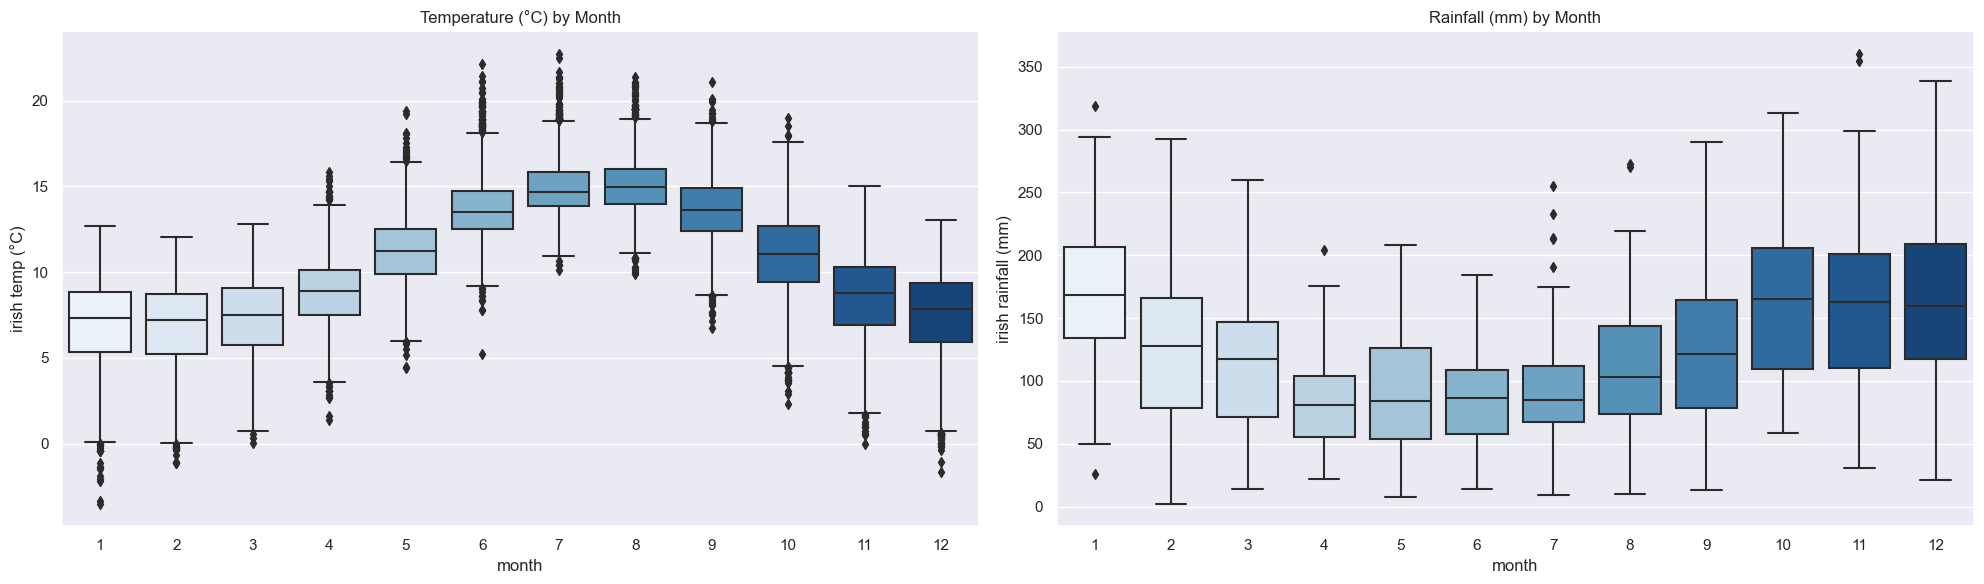

In [16]:
plt.figure(figsize=(20, 6))

# Irish Temperature
ax1 = plt.subplot(1, 2, 1)
sns.boxplot(data=irish_weather_df, x='month', y='irish temp (°C)', palette='Blues')
ax1.set_title('Temperature (°C) by Month')

# Irish Rainfall
ax2 = plt.subplot(1, 2, 2)
sns.boxplot(data=irish_weather_df, x='month', y='irish rainfall (mm)', palette='Blues')
ax2.set_title('Rainfall (mm) by Month')
plt.tight_layout()

#### **Composite Weather DataFrame**

In [17]:
irish_weather_df = irish_weather_df.drop(["month"], axis=1)
irish_weather_df = irish_weather_df.groupby("year").mean()

In [18]:
df  = pd.merge(antarctic_df, irish_weather_df, left_index=True, right_index=True, how="outer")
df

,temp anomaly (°C),CH4 (ppbv),CO2 (ppmv),irish rainfall (mm),irish temp (°C)
year,,,,,
-803718,NaN,NaN,207.285440,NaN,NaN
-803182,NaN,NaN,202.226839,NaN,NaN
-802572,NaN,NaN,204.861938,NaN,NaN
-802059,NaN,NaN,207.498645,NaN,NaN
-801975,NaN,NaN,202.921723,NaN,NaN
...,...,...,...,...,...
2019,NaN,NaN,NaN,141.800000,11.125000
2020,NaN,NaN,NaN,161.791667,10.991667
2021,NaN,NaN,NaN,129.025000,11.141667


Export to csv and json formats.

In [19]:
df.to_csv("./export/weather.csv")
df.to_json("./export/weather.json")

#### **Composite Weather DataFrame**

[13]

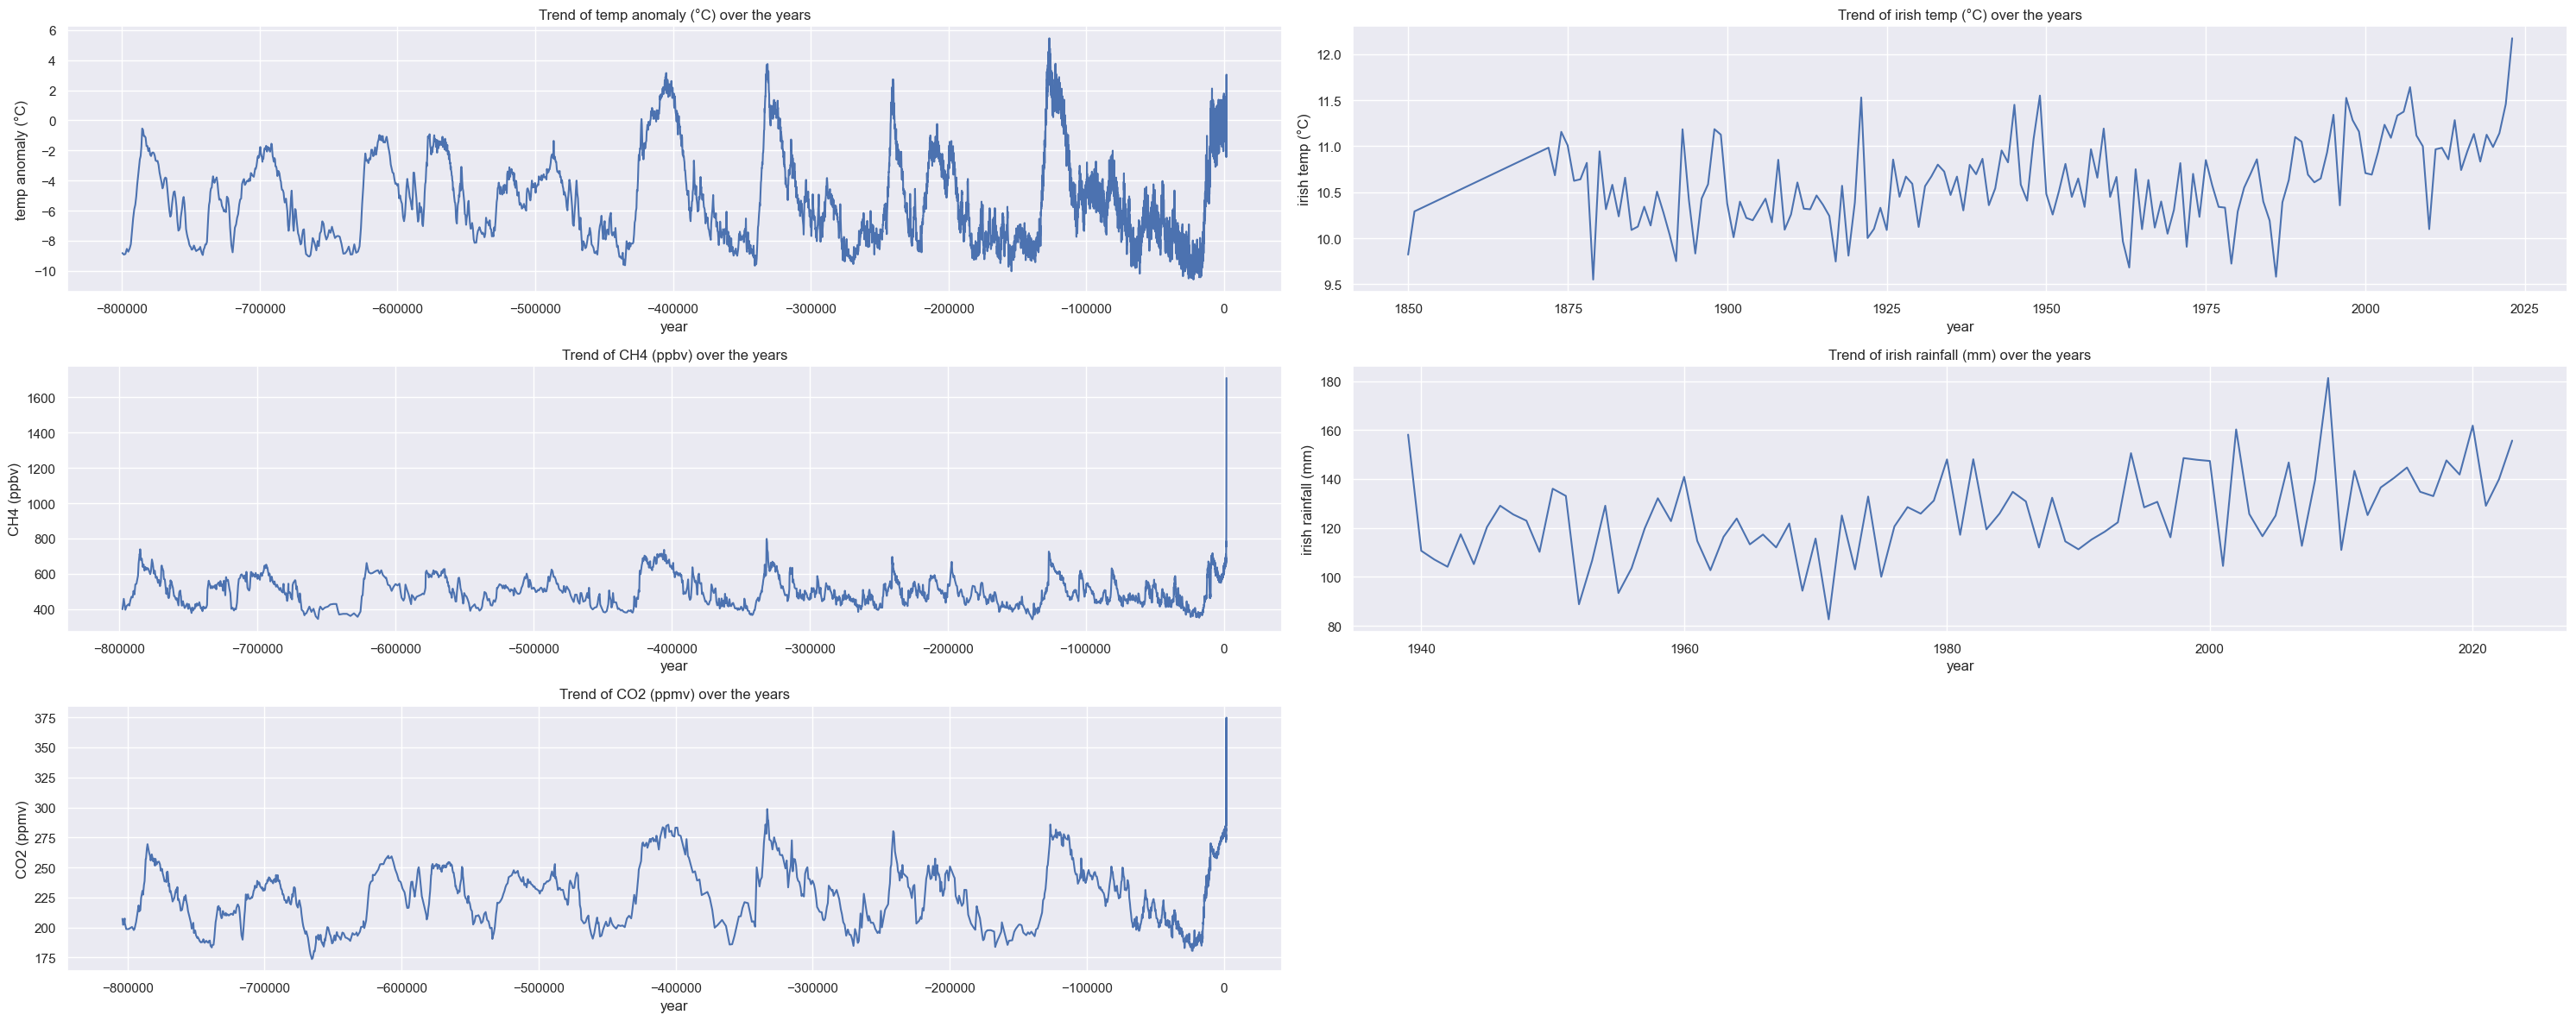

In [20]:
plt.figure(figsize=(30, 12))

variables = ["temp anomaly (°C)", "irish temp (°C)", "CH4 (ppbv)", "irish rainfall (mm)", "CO2 (ppmv)"]

for i, var in enumerate(variables, 1):
    plt.subplot(3, 2, i)
    sns.lineplot(x='year', y=var, data=df)
    plt.title(f'Trend of {var} over the years')
    plt.tight_layout()

Show each variable and how it trends over time. A steep increase at the trail end can be seen. [7]

### **Lead-Lag Correlation Analysis**

[7] [14]

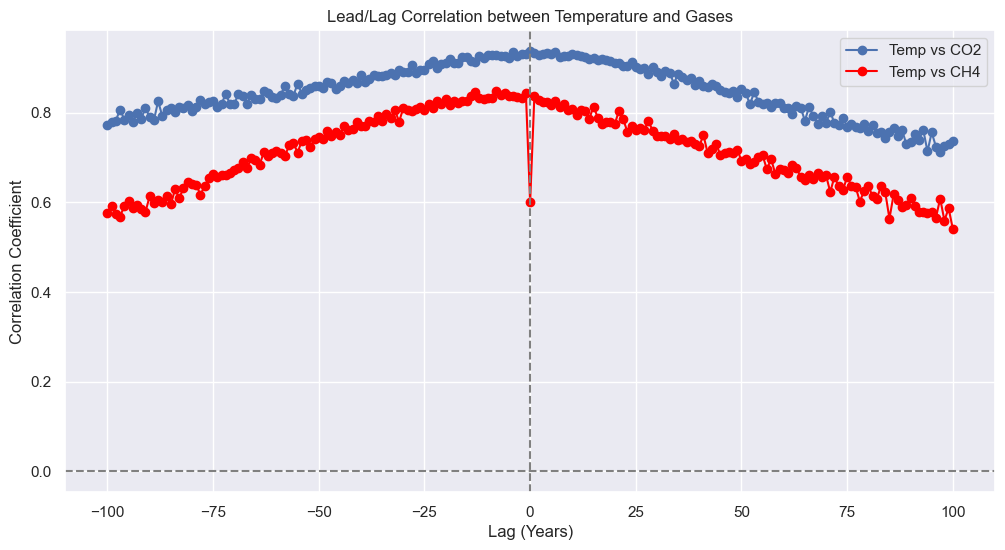

In [21]:
lead_lag_steps = range(-100, 101)  # A range of 200 years before and after
lead_lag_correlations_temp_co2 = []
lead_lag_correlations_temp_ch4 = []

for step in lead_lag_steps:
    shifted_df = df[['temp anomaly (°C)', 'CO2 (ppmv)', 'CH4 (ppbv)']].copy()
    shifted_df['CO2 (ppmv)'] = shifted_df['CO2 (ppmv)'].shift(step)
    shifted_df['CH4 (ppbv)'] = shifted_df['CH4 (ppbv)'].shift(step)
    corr_temp_co2 = shifted_df.corr().iloc[0, 1]  # Temperature vs CO2 correlation
    corr_temp_ch4 = shifted_df.corr().iloc[0, 2]  # Temperature vs CH4 correlation
    lead_lag_correlations_temp_co2.append(corr_temp_co2)
    lead_lag_correlations_temp_ch4.append(corr_temp_ch4)

# Visualizing the correlation with lead/lag
plt.figure(figsize=(12, 6))
plt.plot(lead_lag_steps, lead_lag_correlations_temp_co2, label='Temp vs CO2', marker='o')
plt.plot(lead_lag_steps, lead_lag_correlations_temp_ch4, label='Temp vs CH4', marker='o', color='red')
plt.title('Lead/Lag Correlation between Temperature and Gases')
plt.xlabel('Lag (Years)')
plt.ylabel('Correlation Coefficient')
plt.axhline(y=0, color='gray', linestyle='--')
plt.axvline(x=0, color='gray', linestyle='--')
plt.legend()
plt.grid(True)

The plot illustrates the correlation between CO2 and temperature at different leads/lags (years). The correlation peaks when CO2 is aligned with the temperature (lag = 0), indicating that changes in CO2 levels are closely aligned with changes in temperature without a significant lead or lag in this dataset.

The correlation of methane and temperature is 0.599596 for 0 years, however it is much stronger when shifted in either direction. This seems to be an outlier and possible error in the dataset.

### **Predict Future Global Temperatures**

Followed references [18] [19] throughout this section.

In [22]:
df.drop(['irish temp (°C)', 'irish rainfall (mm)'], axis=1, inplace=True)
df = df.dropna()

Split into train and test data.

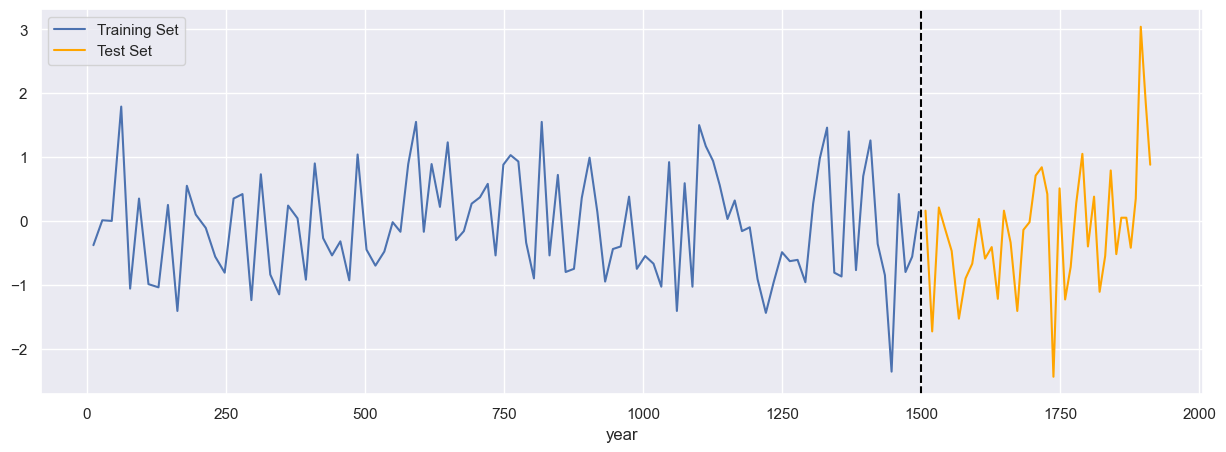

In [23]:
train = df.loc[df.index < 1500]
test = df.loc[df.index >= 1500]

fig, ax = plt.subplots(figsize=(15, 5))
train['temp anomaly (°C)'].plot(ax=ax, label='Training Set')
test['temp anomaly (°C)'].plot(ax=ax, label='Test Set', color='orange')
ax.axvline(1500, color='black', ls='--')
ax.legend(['Training Set', 'Test Set']);

In [24]:
def create_features(df):
    df = df.copy()
    df['century'] = (df.index // 100) + 1
    df['decade'] = (df.index // 10) * 10
    # Creating lagged variables for temperature
    df['temp_lag_10'] = df['temp anomaly (°C)'].shift(10)
    # Rolling averages for temperature - using a 5-year window
    df['temp_5yr_rolling_avg'] = df['temp anomaly (°C)'].rolling(window=5).mean()
    # Interaction terms between CO2 and CH4 levels
    df['co2_ch4_interaction'] = df['CO2 (ppmv)'] * df['CH4 (ppbv)']
    # Polynomial features for CO2 (square and cube)
    df['co2_squared'] = df['CO2 (ppmv)'] ** 2
    df['co2_cubed'] = df['CO2 (ppmv)'] ** 3
    return df

df = create_features(df)

In [25]:
df

,temp anomaly (°C),CH4 (ppbv),CO2 (ppmv),century,decade,temp_lag_10,temp_5yr_rolling_avg,co2_ch4_interaction,co2_squared,co2_cubed
year,,,,,,,,,,
12,-0.38,641.9366,277.326600,1,10,NaN,NaN,178026.094694,76910.043068,2.132920e+07
28,0.01,634.8124,277.881600,1,20,NaN,NaN,176402.685412,77218.183619,2.145751e+07
45,0.00,630.0497,277.683400,1,40,NaN,NaN,174954.342865,77108.070636,2.141163e+07
62,1.79,628.0529,277.306400,1,60,NaN,NaN,174163.088709,76898.839481,2.132454e+07
78,-1.06,628.1454,277.263700,1,70,NaN,0.072,174161.917742,76875.159338,2.131469e+07
...,...,...,...,...,...,...,...,...,...,...
1877,-0.42,821.8706,289.328131,19,1870,0.28,-0.010,237790.284675,83710.767425,2.421988e+07
1886,0.35,837.2930,288.115764,19,1880,1.05,-0.098,241237.312136,83010.693292,2.391669e+07
1895,3.04,850.8181,295.531800,19,1890,-0.40,0.614,251443.804566,87339.044811,2.581147e+07


In [26]:
train = create_features(train)
test = create_features(test)

FEATURES = ['CH4 (ppbv)', 'CO2 (ppmv)', 'century', 'decade', 'temp_lag_10', 'temp_5yr_rolling_avg', 'co2_ch4_interaction', 'co2_squared']
TARGET = 'temp anomaly (°C)'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [27]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:0.99815	validation_1-rmse:1.16290
[100]	validation_0-rmse:0.68316	validation_1-rmse:0.92334
[200]	validation_0-rmse:0.55268	validation_1-rmse:0.90824
[224]	validation_0-rmse:0.53347	validation_1-rmse:0.90835


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

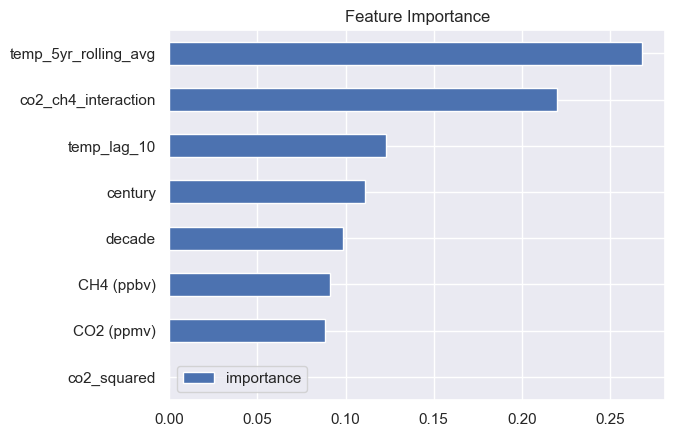

In [28]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

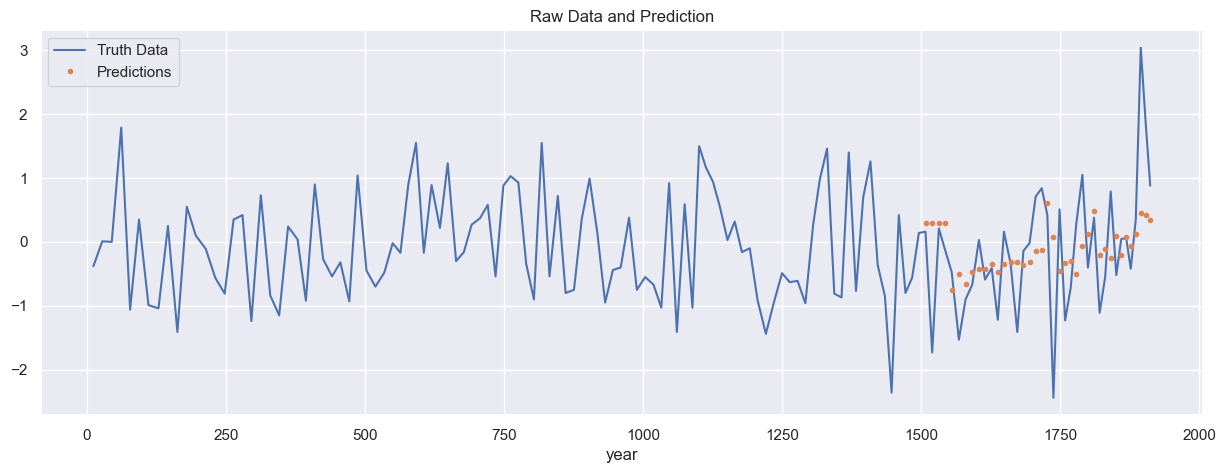

In [29]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['temp anomaly (°C)']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

The predicted data on the 'truth data' seems to correspond decently although it does not predict the dramatic increase in 1895.

**Lag Features**

In [30]:
def add_lags(df):
    target_map = df['temp anomaly (°C)'].to_dict()
    df['lag1'] = (df.index - 10).map(target_map)
    df['lag2'] = (df.index - 20).map(target_map)
    df['lag3'] = (df.index - 30).map(target_map)
    return df

In [31]:
df = add_lags(df)

**Train Using Cross Validation**

In [32]:
tss = TimeSeriesSplit(n_splits=3, test_size=10, gap=50)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['CH4 (ppbv)', 'CO2 (ppmv)', 'century', 'decade', 'temp_lag_10', 'temp_5yr_rolling_avg', 'co2_ch4_interaction', 'co2_squared']
    TARGET = 'temp anomaly (°C)'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:0.91634	validation_1-rmse:1.01191
[100]	validation_0-rmse:0.59222	validation_1-rmse:0.97764
[136]	validation_0-rmse:0.52523	validation_1-rmse:1.01033
[0]	validation_0-rmse:0.95208	validation_1-rmse:1.29647
[100]	validation_0-rmse:0.62424	validation_1-rmse:1.17345
[143]	validation_0-rmse:0.55485	validation_1-rmse:1.20875
[0]	validation_0-rmse:0.94763	validation_1-rmse:1.08876
[83]	validation_0-rmse:0.66324	validation_1-rmse:1.08400


In [33]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 1.0612
Fold scores:[0.9571478949368116, 1.1641844454423387, 1.0623041094831067]


In [34]:
# Retrain on all data
df = create_features(df)

FEATURES = ['CH4 (ppbv)', 'CO2 (ppmv)', 'century', 'decade', 'temp_lag_10', 'temp_5yr_rolling_avg', 'co2_ch4_interaction', 'co2_squared']
TARGET = 'temp anomaly (°C)'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:1.04570
[100]	validation_0-rmse:0.71807
[200]	validation_0-rmse:0.60663
[300]	validation_0-rmse:0.54480
[400]	validation_0-rmse:0.50112
[499]	validation_0-rmse:0.45902


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [35]:
max_year = df.index.max()

# Create a future dataframe with an integer index representing years up to 2050
future_years = range(max_year + 1, 2050)
future_df = pd.DataFrame(index=future_years)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [36]:
future_w_features = df_and_future.query('isFuture').copy()

In [37]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

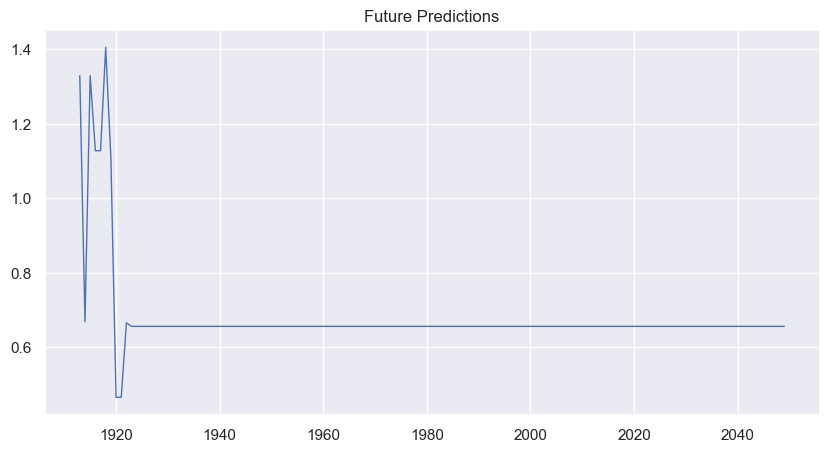

In [39]:
future_w_features['pred'].plot(figsize=(10, 5),
                               ms=1,
                               lw=1,
                               title='Future Predictions');

As shown above the prediction model did not work as intended with a flat line at approx 0.70 degrees celsius.

## **References**

---


1. Australian Nuclear Science and Technology Organisation (n.d.) Historic greenhouse gas concentrations from Antarctic ice core sampling. Available at: https://www.ansto.gov.au/historic-greenhouse-gases (Accessed: 29/12/2023).

1. Bazin, L., et al. (2013) An optimized multi-proxy, multi-site Antarctic ice and gas orbital chronology (AICC2012): 120–800 ka. Climate of the Past, 9, pp. 1715-1731. Available at: https://cp.copernicus.org/articles/9/1715/2013/ (Accessed: 09/01/2024).
   
1. Brownlee, J. (n.d.) How To Resample and Interpolate Your Time Series Data With Python. Machine Learning Mastery. Available at: https://machinelearningmastery.com/resample-interpolate-time-series-data-python/ (Accessed: 11/01/2024).

1. Brownlee, J. (n.d.) Normalization Formula: How To Use It on a Data Set. Machine Learning Mastery. Available at: https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ (Accessed: 31/12/2023).

1. Calmcode (n.d.) Pandas Timestamp Limitations. Available at: https://calmcode.io/til/pandas-timerange.html (Accessed: 17/12/2023).
   
1. Code Review Stack Exchange (n.d.) Parsing a text file into a pandas DataFrame. Available at: https://codereview.stackexchange.com/questions/257729/parsing-a-text-file-into-a-pandas- (Accessed: 01/01/2024).

1. Hyndman, R.J. and Athanasopoulos, G. (n.d.) Forecasting: Principles and Practice (3rd ed). Available at: https://otexts.com/fpp3/ (Accessed: 03/12/2023). ​

1. Loulergue, L.; Schilt, A.; Spahni, R.; Masson-Delmotte, V.; Blunier, T.; Lemieux, B.; Barnola, J.-M.; Raynaud, D.; Stocker, T.F.; Chappellaz, J.A. (2009-12-11): NOAA/WDS Paleoclimatology - EPICA Dome C - 800KYr Methane Data. NOAA National Centers for Environmental Information. https://doi.org/10.25921/gfsj-jc86. (Accessed: 23/12/2023).
MachineHack (n.d.) What is the lead-lag effect, and how is it used in statistics? Available at: https://machinehack.com/story/what-is-the-lead-lag-effect-and-how-is-it-used-in-statistics (Accessed: 04/01/2024).

1. Nehrbass-Ahles, Christoph; Shin, Jinhwa; Schmitt, Jochen; Bereiter, Bernhard; Joos, Fortunat; Schilt, Adrian; Schmidely, Loïc; Silva, Lucas; Teste, Grégory; Grilli, Roberto; Chappellaz, Jérôme A; Hodell, David A; Fischer, Hubertus; Stocker, Thomas F (2020): Compilation of CH4 records derived from the EPICA Dome C ice core covering MIS 9e - 12a. Universität Bern, PANGAEA, https://doi.org/10.1594/PANGAEA.914908, In: Nehrbass-Ahles, Christoph; Shin, Jinhwa; Schmitt, Jochen; Bereiter, Bernhard; Joos, Fortunat; Schilt, Adrian; Schmidely, Loïc; Silva, Lucas; Teste, Grégory; Grilli, Roberto; Chappellaz, Jérôme A; Hodell, David A; Fischer, Hubertus; Stocker, Thomas (2020): High-resolution atmospheric CO2 and CH4 records derived from the EPICA Dome C ice core and stable isotope records from marine sediment core IODP Site U1385 covering MIS 9e - 12a. PANGAEA, https://doi.org/10.1594/PANGAEA.915146

1. MET Eireann. Long Term Data Sets. https://www.met.ie/climate/available-data/long-term-data-sets/ (Accessed: 17/12/2023).

1. pandas (n.d.) pandas.DataFrame.merge. Available at: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html (Accessed: 21/12/2023).

1. pandas (n.d.) pandas.read_excel. Available at: https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html

1. Stack Overflow (n.d.) How to concatenate multiple column values into a single column in Pandas dataframe. Available at: https://stackoverflow.com/questions/39291499/how-to-concatenate-multiple-column-values-into-a-single-column-in-pandas-datafra (Accessed: 20/12/2023).

1. Stack Overflow (n.d.) How to Use Lagged Time-Series Variables in a Python Pandas Regression Model? Available at: https://stackoverflow.com/questions/39840890/how-to-use-lagged-time-series-variables-in-a-python-pandas-regression-model (Accessed: 31/12/2023).

1. Stack Overflow (n.d.) How to concatenate multiple column values into a single column in Pandas dataframe. Available at: https://stackoverflow.com/questions/39291499/how-to-concatenate-multiple-column-values-into-a-single-column-in-pandas-datafra (Accessed: 20/12/2023).

1. Open Data Unit. Valentia Observatory Monthly Data. https://data.gov.ie/dataset/valentia-observatory-monthly-data (Accessed: 17/12/2023).

1. University of Pennsylvania Libraries (n.d.) Importing Files (Web Scraping). Available at: https://guides.library.upenn.edu/penntdm/python/import_files (Accessed: 26/12/2023).

1. YouTube: Rob Mulla (n.d.) Time Series Forecasting with XGBoost - Advanced Methods. Available at: https://www.youtube.com/watch?v=z3ZnOW-S550 (Accessed: 30/12/2023).

1. YouTube: Rob Mulla (n.d.) Time Series Forecasting with XGBoost - Use python and machine learning to predict energy consumption. Available at: https://www.youtube.com/watch?v=vV12dGe_Fho (Accessed: 17/12/2023).

***
# End